In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/amex-default-prediction/sample_submission.csv
/kaggle/input/amex-default-prediction/train_data.csv
/kaggle/input/amex-default-prediction/test_data.csv
/kaggle/input/amex-default-prediction/train_labels.csv
/kaggle/input/amex-parquet/test_data.parquet
/kaggle/input/amex-parquet/train_data.parquet


# Data preprocessing

In [2]:
df_train = pd.read_parquet('/kaggle/input/amex-parquet/train_data.parquet')
df_test = pd.read_parquet('/kaggle/input/amex-parquet/test_data.parquet')

In [3]:
df_train.shape, df_test.shape

((5531451, 191), (11363762, 190))

In [4]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
P_2,5485466.0,0.656334,0.244649,-4.589548e-01,0.480331,0.694295,0.864816,1.010000
D_39,5531451.0,0.153117,0.270071,5.026190e-09,0.004528,0.009057,0.236641,5.389619
B_1,5531451.0,0.124010,0.211987,-7.588799e+00,0.008864,0.031330,0.125902,1.324060
B_2,5529435.0,0.621489,0.401488,9.192280e-09,0.105331,0.814333,1.002403,1.010000
R_1,5531451.0,0.078803,0.226397,1.534223e-09,0.002896,0.005782,0.008661,3.256284
...,...,...,...,...,...,...,...,...
D_142,944408.0,0.390799,0.236182,-1.453934e-02,0.199399,0.382136,0.559307,2.229368
D_143,5429903.0,0.178802,0.378950,5.549692e-09,0.003028,0.006053,0.009076,1.010000
D_144,5490724.0,0.052390,0.182514,2.500991e-09,0.002753,0.005508,0.008260,1.343331
D_145,5429903.0,0.062335,0.193494,1.226024e-09,0.003028,0.006053,0.009081,4.827630


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5531451 entries, 0 to 5531450
Columns: 191 entries, customer_ID to target
dtypes: float32(185), int64(2), object(4)
memory usage: 4.1+ GB


**Knowing null values and drop it**

In [6]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(60)

,Total,Percent
D_87,5527586,0.999301
D_88,5525447,0.998915
D_108,5502513,0.994768
D_110,5500117,0.994335
D_111,5500117,0.994335
B_39,5497819,0.993920
D_73,5475595,0.989902
B_42,5459973,0.987078
D_134,5336752,0.964801
D_135,5336752,0.964801


In [7]:
null_columns=df_train.columns[df_train.isnull().any()]

In [8]:
df_train.drop(columns=null_columns, inplace=True)

In [9]:
df_test.drop(columns=null_columns, inplace=True)

In [10]:
df_train.isnull().sum()

customer_ID    0
S_2            0
D_39           0
B_1            0
R_1            0
              ..
D_96           0
B_36           0
D_127          0
R_28           0
target         0
Length: 69, dtype: int64

In [11]:
df_train.drop(columns=['customer_ID'], inplace=True)

In [12]:
categorical = df_train.select_dtypes(include = "object").columns
for i in range(0, len(categorical)):
    print(df_train[categorical[i]].value_counts())
    print('****************************************\n')

2018-02-17    26715
2018-01-20    25016
2018-02-03    23966
2018-03-17    23373
2018-02-24    23356
              ...  
2017-05-07     7895
2017-03-05     7879
2017-03-12     7797
2017-03-19     7788
2017-04-16     6990
Name: S_2, Length: 396, dtype: int64
****************************************

CO    4119621
CR     930133
CL     438390
XZ      25786
XM      10556
XL       6965
Name: D_63, dtype: int64
****************************************



In [13]:
df_train.drop(columns=['S_2'], inplace=True)

In [14]:
df_test.drop(columns=['S_2'], inplace=True)

In [15]:
D_63 = {'CO':0, 'CR':1, 'CL':2, 'XZ':3, 'XM':4, 'XL':5}
df_train['D_63'].replace(D_63, inplace=True)
df_test['D_63'].replace(D_63, inplace=True)

# Data visualization

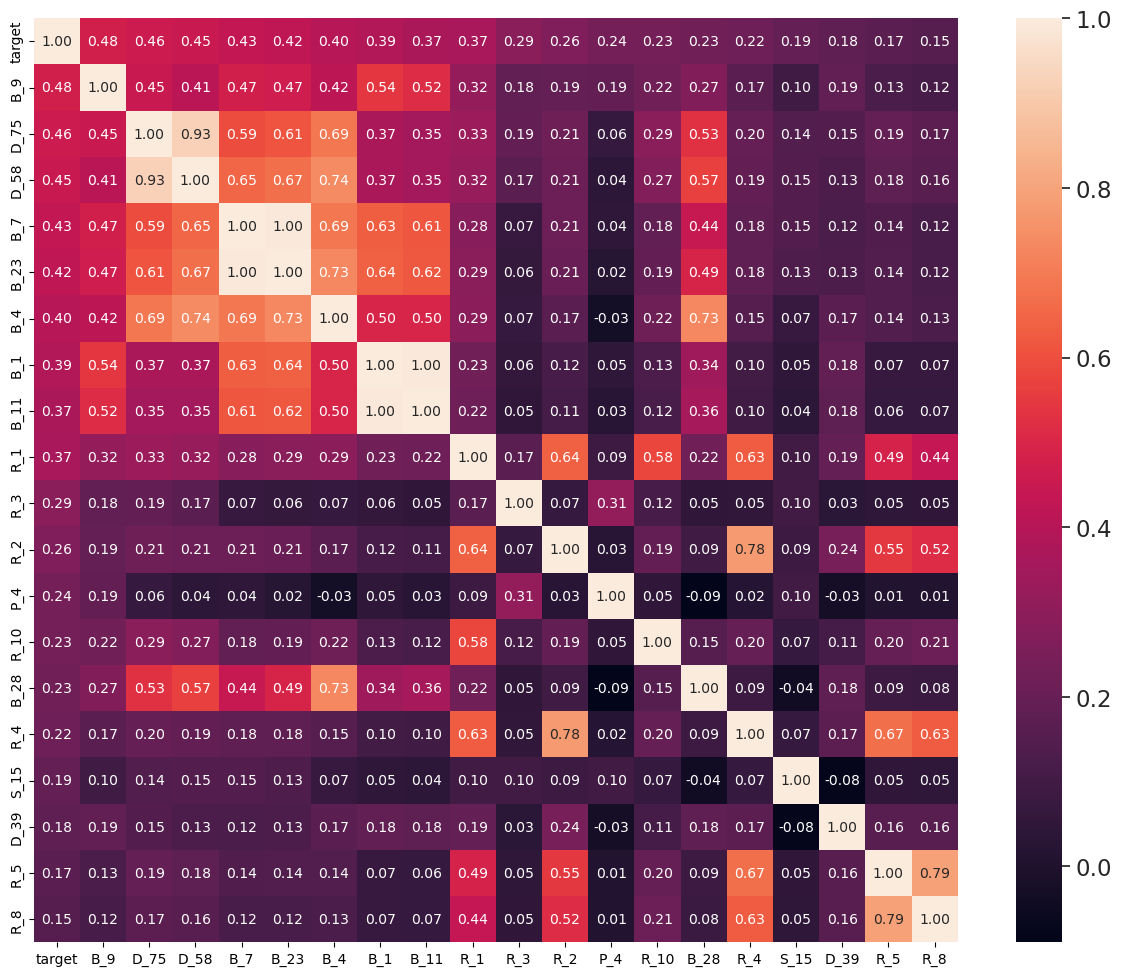

In [16]:
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(15, 12))
cols = corrmat.nlargest(20, 'target')['target'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10},
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [17]:
cols = cols[1:]
cols

Index(['B_9', 'D_75', 'D_58', 'B_7', 'B_23', 'B_4', 'B_1', 'B_11', 'R_1',
       'R_3', 'R_2', 'P_4', 'R_10', 'B_28', 'R_4', 'S_15', 'D_39', 'R_5',
       'R_8'],
      dtype='object')

<AxesSubplot:xlabel='target', ylabel='count'>

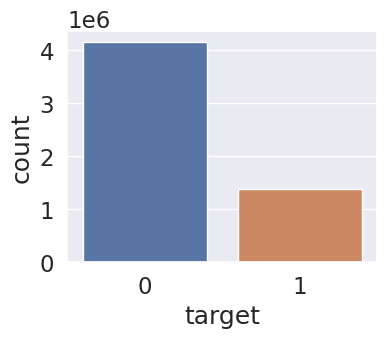

In [18]:
plt.figure(figsize=(4,3))
sns.countplot(x=df_train['target'])

Text(0.5, 0.98, 'Relation between target and nine important features')

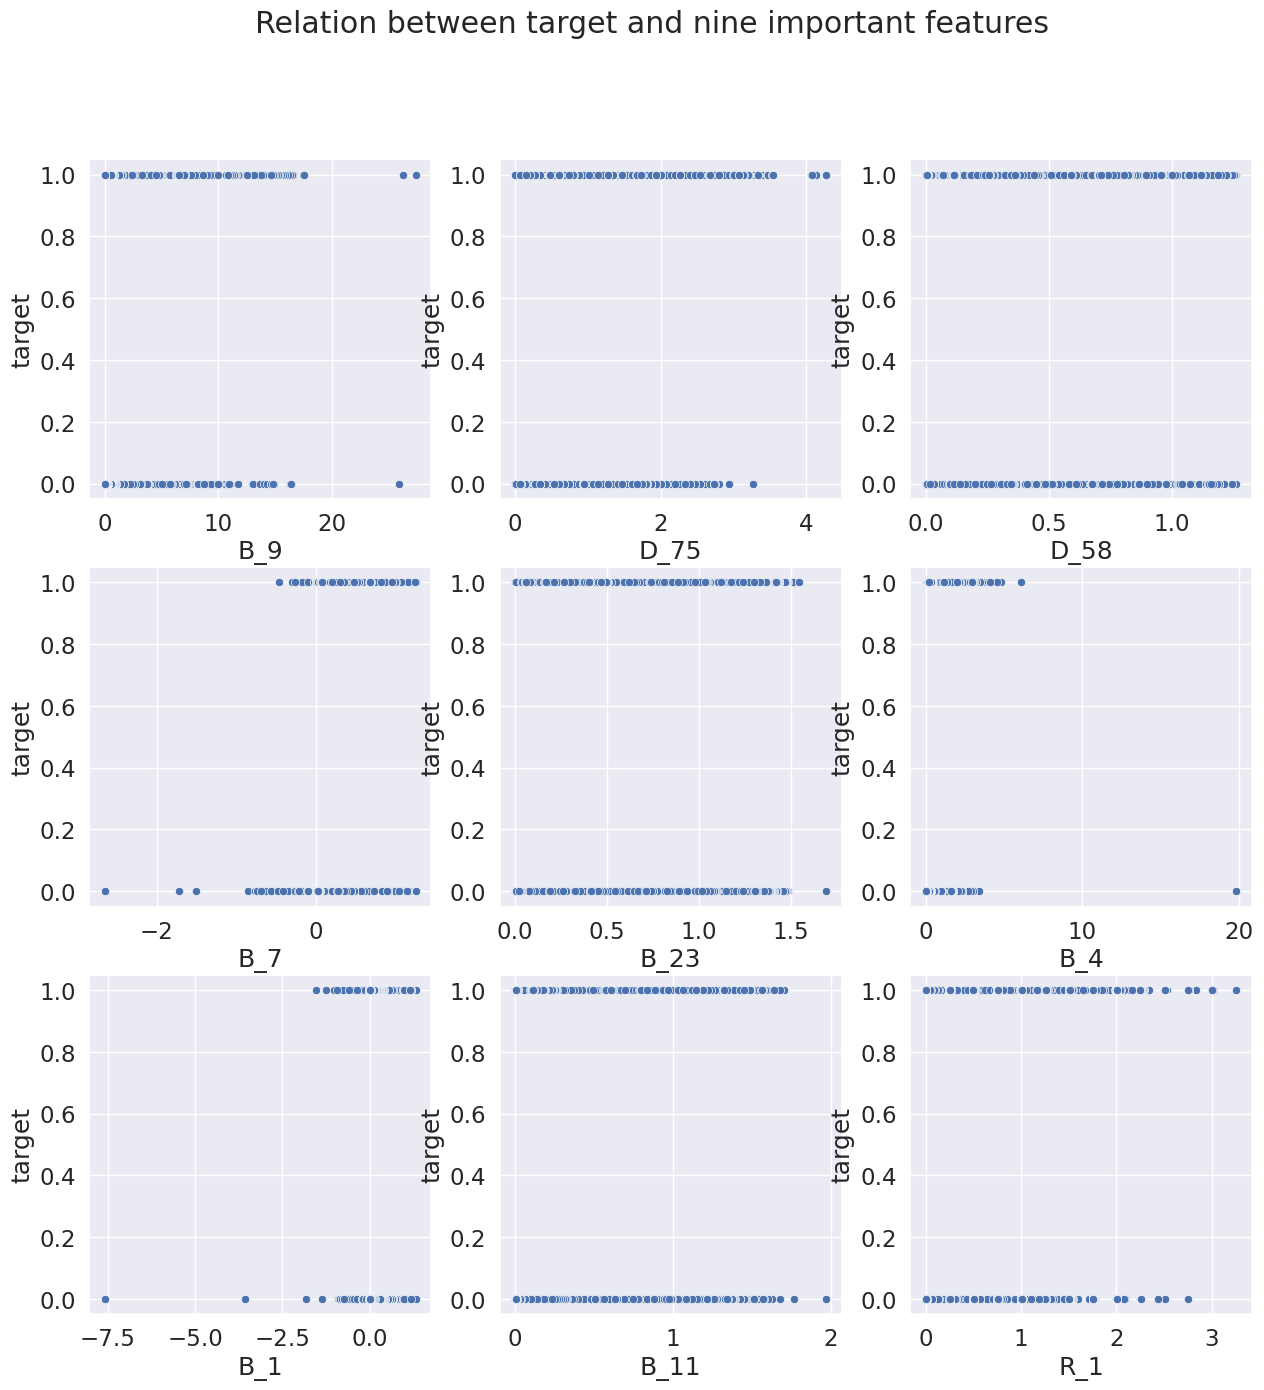

In [19]:
plt.figure(figsize=(15,15))
for i in range(len(cols[:9])):
    plt.subplot(3,3, i+1) #the figure has 3 row, 3 columns, and this plot is the i-th plot.
    sns.scatterplot(x=df_train[cols[i]], y=df_train['target'])
plt.suptitle('Relation between target and nine important features')

Text(0.5, 0.98, 'Values for nine important features')

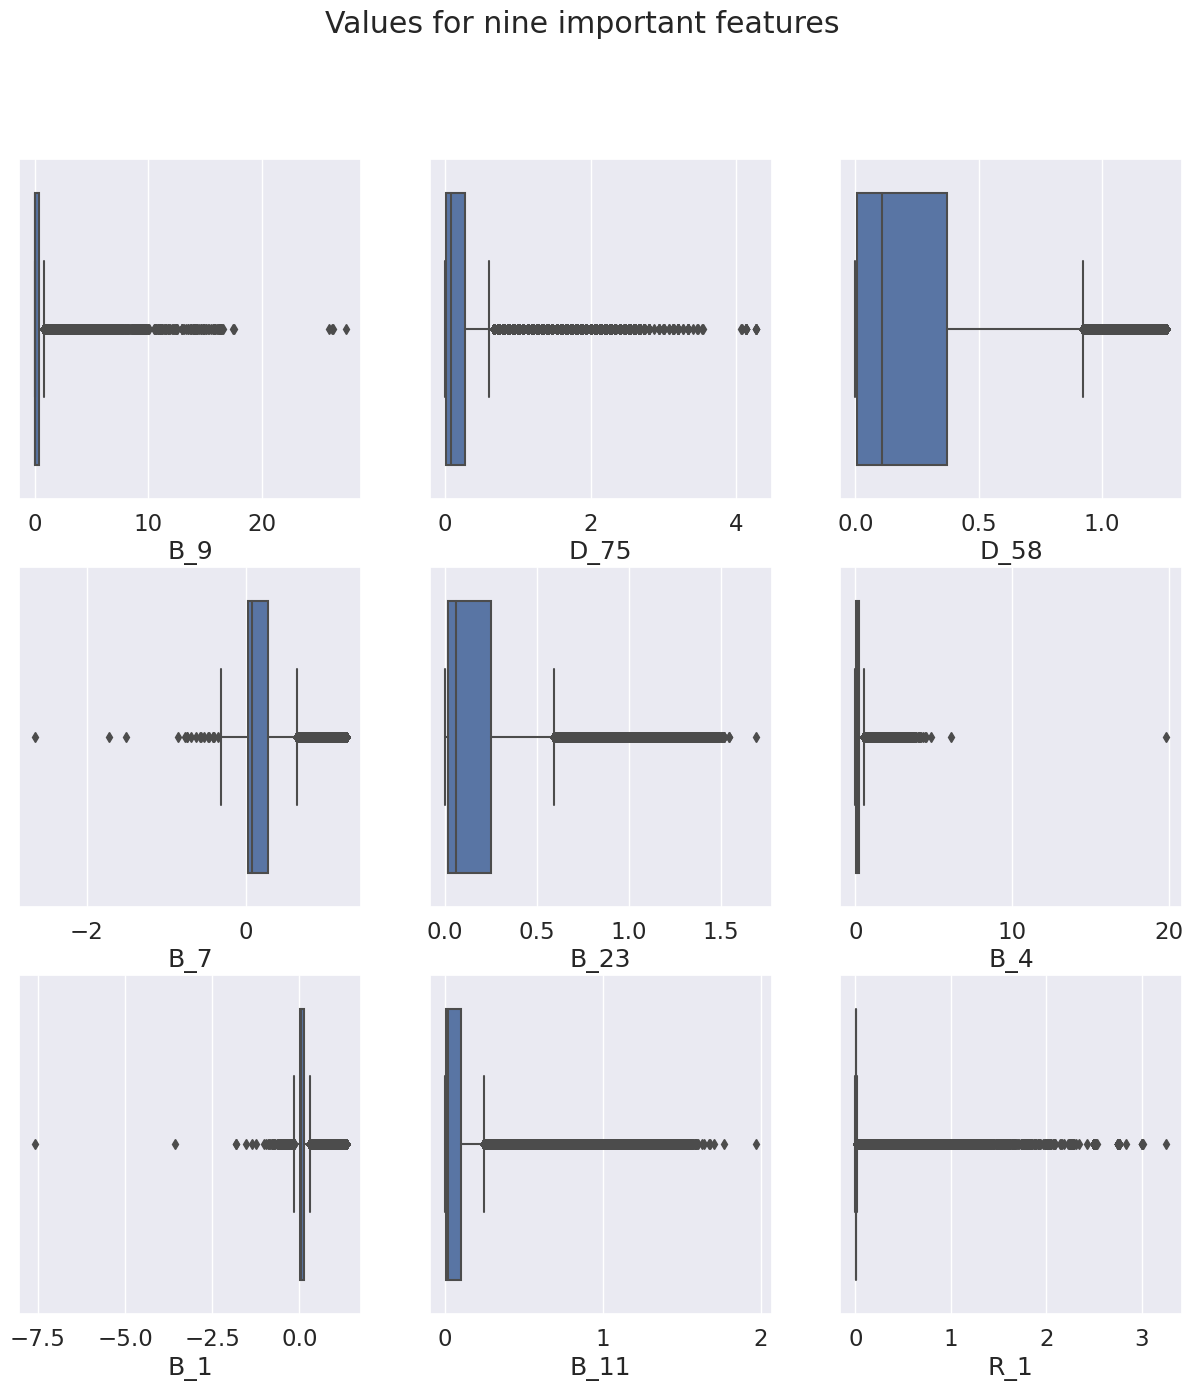

In [20]:
plt.figure(figsize=(15,15))
for i in range(len(cols[:9])):
    plt.subplot(3,3, i+1) #the figure has 3 row, 3 columns, and this plot is the i-th plot.
    sns.boxplot(x=df_train[cols[i]])
plt.suptitle('Values for nine important features')

**Removing outliers**

In [21]:
#print(len(df_train[(df_train['B_9'] > 15)]))
df_train.drop(df_train[(df_train['B_9'] > 15)].index, inplace=True)

In [22]:
#print(len(df_train[(df_train['D_75'] > 3.5)]))
df_train.drop(df_train[(df_train['D_75'] > 3.5)].index, inplace=True)

In [23]:
#print(len(df_train[(df_train['B_7'] < -0.5)]))
df_train.drop(df_train[(df_train['B_7'] < -0.5)].index, inplace=True)

In [24]:
#print(len(df_train[(df_train['B_23'] > 1.5)]))
df_train.drop(df_train[(df_train['B_23'] > 1.5)].index, inplace=True)

In [25]:
#print(len(df_train[(df_train['B_4'] > 4)]))
df_train.drop(df_train[(df_train['B_4'] > 4)].index, inplace=True)

In [26]:
#print(len(df_train[(df_train['B_1'] < -0.5)]))
df_train.drop(df_train[(df_train['B_1'] < -0.5)].index, inplace=True)

In [27]:
#print(len(df_train[(df_train['B_11'] > 1.6)]))
df_train.drop(df_train[(df_train['B_11'] > 1.6)].index, inplace=True)

In [28]:
#print(len(df_train[(df_train['R_1'] > 2.6)]))
df_train.drop(df_train[(df_train['R_1'] > 2.6)].index, inplace=True)

# Balancing for data

In [29]:
df_majority_0 = df_train[(df_train['target']==0)] 
df_minority_1 = df_train[(df_train['target']==1)] 

df_minority_upsampled = resample(df_minority_1, 
                                 replace=True,    
                                 n_samples= 4153544, 
                                 random_state=44) 

df_upsampled = pd.concat([df_minority_upsampled, df_majority_0])

<AxesSubplot:xlabel='target', ylabel='count'>

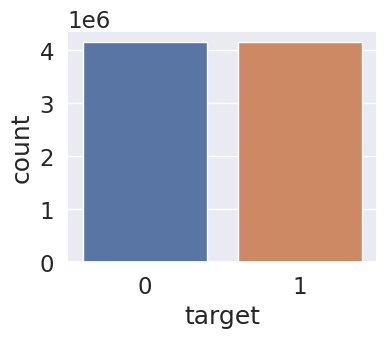

In [30]:
plt.figure(figsize=(4,3))
sns.countplot(x=df_upsampled['target'])

In [31]:
X = df_upsampled[cols]
y = df_upsampled['target']

# Modeling stage

In [32]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, train_size=0.98, shuffle=True, random_state=100)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, train_size=0.5,shuffle=True,random_state=100)

**LogisticRegressionModel**

In [33]:
LogisticRegressionModel = LogisticRegression(penalty='l2',solver='sag',C=2.0,random_state=44)
LogisticRegressionModel.fit(X_train, y_train)

#Calculating Details
print('LogisticRegressionModel Train Score is : ' , LogisticRegressionModel.score(X_train, y_train))
print('LogisticRegressionModel Test Score is : ' , LogisticRegressionModel.score(X_test, y_test))

LogisticRegressionModel Train Score is :  0.8248783372350093
LogisticRegressionModel Test Score is :  0.8268589519808357


In [34]:
CrossValidateValues2 = cross_validate(LogisticRegressionModel, X_val, y_val, cv=5, return_train_score = True)

# Showing Results
print('Train Score Value : ', CrossValidateValues2['train_score'])
print('Test Score Value : ', CrossValidateValues2['test_score'])
print('Fit Time : ', CrossValidateValues2['fit_time'])
print('Score Time : ', CrossValidateValues2['score_time'])

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Train Score Value :  [0.82550861 0.8242924  0.82465354 0.82525543 0.82388612]
Test Score Value :  [0.8228709  0.82659203 0.823101   0.82165643 0.82743469]
Fit Time :  [3.9261322  3.96519089 4.24686074 4.12309647 4.22716951]
Score Time :  [0.01099563 0.00716734 0.0067637  0.00652671 0.00669193]


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


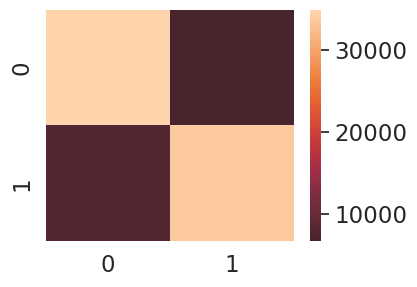

Confusion Matrix is
 [[34929  6676]
 [ 7707 33759]]


In [35]:
y_pred = LogisticRegressionModel.predict(X_test)

plt.figure(figsize=(4,3))
CM = confusion_matrix(y_test, y_pred)
sns.heatmap(CM, center=True)
plt.show()

print('Confusion Matrix is\n', CM)

In [36]:
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83     41605
           1       0.83      0.81      0.82     41466

    accuracy                           0.83     83071
   macro avg       0.83      0.83      0.83     83071
weighted avg       0.83      0.83      0.83     83071

0.8268589519808357


**DecisionTreeClassifierModel**

In [37]:
DecisionTreeClassifierModel = DecisionTreeClassifier(criterion='entropy',max_depth=10,random_state=44)
DecisionTreeClassifierModel.fit(X_train, y_train)

#Calculating Details
print('DecisionTreeClassifierModel Train Score is : ' , DecisionTreeClassifierModel.score(X_train, y_train))
print('DecisionTreeClassifierModel Test Score is : ' , DecisionTreeClassifierModel.score(X_test, y_test))

DecisionTreeClassifierModel Train Score is :  0.8299938360971808
DecisionTreeClassifierModel Test Score is :  0.8318426406327117


In [38]:
CrossValidateValues3 = cross_validate(DecisionTreeClassifierModel, X_val, y_val, cv=5, return_train_score = True)

# Showing Results
print('Train Score Value : ', CrossValidateValues3['train_score'])
print('Test Score Value : ', CrossValidateValues3['test_score'])
print('Fit Time : ', CrossValidateValues3['fit_time'])
print('Score Time : ', CrossValidateValues3['score_time'])

Train Score Value :  [0.84523595 0.84391411 0.84128083 0.84206329 0.84332726]
Test Score Value :  [0.81558832 0.81864692 0.81593837 0.81226676 0.81702179]
Fit Time :  [2.90755224 2.72939754 2.35056162 2.37970901 2.3545115 ]
Score Time :  [0.00775695 0.00587749 0.00599098 0.00653386 0.00581861]


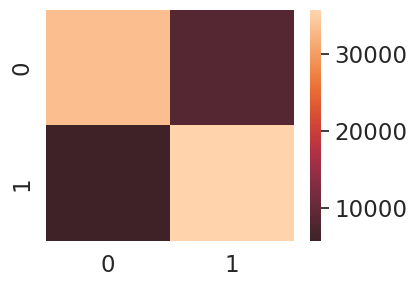

Confusion Matrix is
 [[33297  8308]
 [ 5661 35805]]


In [39]:
y_pred_DT = DecisionTreeClassifierModel.predict(X_test)

plt.figure(figsize=(4,3))

CM_DT = confusion_matrix(y_test, y_pred_DT)
sns.heatmap(CM_DT, center=True)
plt.show()

print('Confusion Matrix is\n', CM_DT)

In [40]:
print(classification_report(y_test, y_pred_DT))
print(accuracy_score(y_test, y_pred_DT))

              precision    recall  f1-score   support

           0       0.85      0.80      0.83     41605
           1       0.81      0.86      0.84     41466

    accuracy                           0.83     83071
   macro avg       0.83      0.83      0.83     83071
weighted avg       0.83      0.83      0.83     83071

0.8318426406327117


**XGBClassifierModel**

In [41]:
XGBClassifierModel = XGBClassifier(n_estimators=100, max_depth=15, eta=0.01, subsample=0.6, colsample_bytree=0.8) 
XGBClassifierModel.fit(X_train, y_train)

#Calculating Details
print('XGBClassifierModel Train Score is : ' , XGBClassifierModel.score(X_train, y_train))
print('XGBClassifierModel Test Score is : ' , XGBClassifierModel.score(X_test, y_test))

XGBClassifierModel Train Score is :  0.858942437402238
XGBClassifierModel Test Score is :  0.8530293363508324


In [42]:
CrossValidateValues4 = cross_validate(XGBClassifierModel, X_val, y_val, cv=5, return_train_score = True)

# Showing Results
print('Train Score Value : ', CrossValidateValues4['train_score'])
print('Test Score Value : ', CrossValidateValues4['test_score'])
print('Fit Time : ', CrossValidateValues4['fit_time'])
print('Score Time : ', CrossValidateValues4['score_time'])

Train Score Value :  [0.9127844  0.91256    0.91254495 0.91307161 0.91256   ]
Test Score Value :  [0.83286187 0.83676417 0.8365836  0.83393524 0.83333333]
Fit Time :  [51.38579535 50.5566678  50.32589984 52.611094   50.59978294]
Score Time :  [0.0919745  0.22145891 0.11119008 0.18508267 0.09202504]


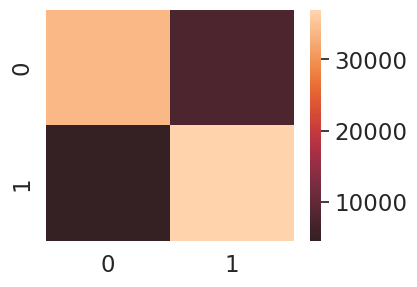

Confusion Matrix is
 [[33902  7703]
 [ 4506 36960]]


In [43]:
y_pred_x = XGBClassifierModel.predict(X_test)
CM_x = confusion_matrix(y_test, y_pred_x)

plt.figure(figsize=(4,3))
sns.heatmap(CM_x, center=True)
plt.show()

print('Confusion Matrix is\n', CM_x)

In [44]:
print(classification_report(y_test, y_pred_x))
print(accuracy_score(y_test, y_pred_x))

              precision    recall  f1-score   support

           0       0.88      0.81      0.85     41605
           1       0.83      0.89      0.86     41466

    accuracy                           0.85     83071
   macro avg       0.86      0.85      0.85     83071
weighted avg       0.86      0.85      0.85     83071

0.8530293363508324


**Submission**

In [45]:
#x_test = df_test[cols]

In [46]:
#y_pred_gbr = GBRModel.predict(x_test)
#y_pred_rf = RandomForestRegressorModel.predict(x_test)
#y_pred_x = XGBClassifierModel.predict(x_test)

In [47]:
#submission = df_test[["customer_ID"]] 
#submission["prediction"] = y_pred_x
#submission.to_csv('output.csv', index=False)